In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plot
# we can use the LabelEncoder to encode the gender feature
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier

# oversample the minority class using SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter
from itertools import combinations


np.random.seed(42)

In [2]:
# load the dataset 
df = pd.read_csv('./data/ToddlerAutismdatasetJuly2018.csv')
# print the dimensionality of the dataframe 
print(f"dataframe shape:\n{df.shape}\n")
# print the names of the columns that can be used as features when training the machine learning model 
print(f"dataframe columns:\n{df.columns}\n")
# print the different data types that can be identified from the entire dataset 
print(f"dataframe info:\n{df.info()}\n")

dataframe shape:
(1054, 19)

dataframe columns:
Index(['Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'Age_Mons', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Case_No                 1054 non-null   int64 
 1   A1                      1054 non-null   int64 
 2   A2                      1054 non-null   int64 
 3   A3                      1054 non-null   int64 
 4   A4                      1054 non-null   int64 
 5   A5                      1054 non-null   int64 
 6   A6                      1054 non-null   int64 
 7   A7                      1054 non-null   int64 
 8   A8                      1054 non-null   int64 
 9   A9                      1054 no

0
dataframe shape:
(1054, 19)

dataframe columns:
Index(['Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'Age_Mons', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Case_No                 1054 non-null   int64 
 1   A1                      1054 non-null   int64 
 2   A2                      1054 non-null   int64 
 3   A3                      1054 non-null   int64 
 4   A4                      1054 non-null   int64 
 5   A5                      1054 non-null   int64 
 6   A6                      1054 non-null   int64 
 7   A7                      1054 non-null   int64 
 8   A8                      1054 non-null   int64 
 9   A9                      1054 

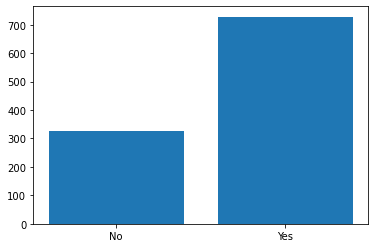

nan
correlation with column: A1
A1                1.000000
Qchat-10-Score    0.614064
A2                0.463227
A6                0.373083
A7                0.332705
A9                0.322226
A5                0.284808
A4                0.247524
A3                0.244362
A8                0.208197
A10               0.130966
Age_Mons          0.040508
Name: A1, dtype: float64

correlation with column: A2
A2                1.000000
Qchat-10-Score    0.592424
A1                0.463227
A6                0.309461
A7                0.294314
A9                0.268784
A4                0.265867
A5                0.259105
A8                0.251865
A3                0.206927
A10               0.157498
Age_Mons          0.037744
Name: A2, dtype: float64

correlation with column: A3
A3                1.000000
Qchat-10-Score    0.592885
A4                0.547100
A9                0.379129
A5                0.349086
A6                0.297719
A1                0.244362
A8                0.243

In [36]:
# Validate there no missing missing rwos in data
missing_rows = df[df.isnull().any(axis=1)]
print(missing_rows.size)

# load the dataset 
df = pd.read_csv('./data/ToddlerAutismdatasetJuly2018.csv')
# print the dimensionality of the dataframe 
print(f"dataframe shape:\n{df.shape}\n")
# print the names of the columns that can be used as features when training the machine learning model 
print(f"dataframe columns:\n{df.columns}\n")
# print the different data types that can be identified from the entire dataset 
print(f"dataframe info:\n{df.info()}\n")

# plotting the class distrabution for our dataset.
x_axis = ['No', 'Yes']
y_axis = [len(df.loc[df.Class == 'No']),len(df.loc[df.Class == 'Yes']) ]
plot.bar(x_axis, y_axis)
plot.show()

print(df.loc[df.Class==1, 'Age_Mons'].median())
# identify features that represent a notable correlation
df_corr = df.drop(columns=['Class','Case_No'])
corr = df_corr.corr()
for col in corr.columns:
    print(f"correlation with column: {col}")
    print(corr[col].sort_values(ascending=False))
    print()

split = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

for train_index, test_index in split.split(df, df['Class']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]


# print the dimensionality of the test dataset 
print(train_set.shape)
# print the dimensionality of the training dataset 
print(test_set.shape)

# print the proportional distribution of the classes to identify whether or not the classes are equally(or closer) distributed between the train and test datasets 
print(train_set.Class.value_counts()/len(train_set))
print(test_set.Class.value_counts()/len(test_set))


##### Model Development

In [4]:
# separate the features and the labels to be used in model development, dropped Case_No and Who completed the test due to irrelevance 
data = train_set.drop(columns=['Class', 'Case_No','Who completed the test', 'Qchat-10-Score'])
labels = train_set['Class'].to_numpy(copy=True)


# print the dimensionality of the dataset and the labels
print(data.shape)
print(labels.shape)


# create the necessary pipelines and combine the features to be used as the training data for the given algorithm 
numerical_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

num_feature_names = data.drop(columns=['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD']).columns
cat_feature_names = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD']

full_pipeline = ColumnTransformer([
        ("num", numerical_pipeline, num_feature_names),
        ("cat", OneHotEncoder(), cat_feature_names),
    ])

input_x = full_pipeline.fit_transform(data)


questions = [0,1,2,3,4,5,6,7,8,9]

question_combinations = [",".join(map(str, comb)) for comb in combinations(questions, 3)]
training_data_list = []

for i, c in enumerate(question_combinations):
    question_list = c.split(',')
    training_data_list.append([])
    for row in input_x:
        training_data_list[i].append(np.delete(row, [int(question_list[0]),int(question_list[1]),int(question_list[2])]))

print(training_data_list[0:3])
print(len(input_x[0]))
print(training_data_list[0])



(737, 15)
(737,)
[[array([-1.03171012, -1.03451666,  0.85680666,  0.73829085,  1.08057719,
        1.03171012,  0.83088325,  0.05205158,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ]), array([ 0.96926451,  0.96663499,  0.85680666,  0.73829085,  1.08057719,
        1.03171012, -1.20353853,  1.05498004,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ]), array([-1.03171012, -1.03451666, -1.16712445, -1.35447975,  1.08057719,
       -0.96926451,  0.83088325,  1.05498004,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.     

##### Creating different models to train the data set on

In [5]:
model_svc = SVC()
model_dtree = DecisionTreeClassifier(random_state=42)
model_rforest = RandomForestClassifier(random_state=42)
model_nb = GaussianNB()


In [29]:

scoring = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'gamma':[0.001, 0.0001]}
gridSearchCV_svm = GridSearchCV(model_svc, parameters, scoring=scoring, n_jobs = -1, refit='bal_accuracy')

parameters = {'max_depth':(3, 4), 'min_samples_split':[5, 10], 'min_samples_leaf':[10, 20]}
gridSearchCV_dtc = GridSearchCV(model_dtree, parameters, scoring=scoring, n_jobs = -1, refit='bal_accuracy')

parameters = {}  # param_grid={}
gridSearchCV_nby = GridSearchCV(model_nb, parameters, scoring=scoring, n_jobs = -1, refit='bal_accuracy')



parameters = {'n_estimators':[100, 200], 'max_depth':[3, 5], 'bootstrap':(True, False)}
gridSearchCV_rdf = GridSearchCV(model_rforest, parameters, scoring=scoring, n_jobs = -1, refit='bal_accuracy')
# fit the training data
gridSearchCV_dtc_list = []
gridSearchCV_rdf_list = []
gridSearchCV_svm_list = []
gridSearchCV_nby_list = []


#TRain all model with different combination of questions
for i in range(0,120):
    scoring = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'gamma':[0.001, 0.0001]}
    gridSearchCV_svm = GridSearchCV(model_svc, parameters, scoring=scoring, n_jobs = -1, refit='bal_accuracy')

    parameters = {'max_depth':(3, 4), 'min_samples_split':[5, 10], 'min_samples_leaf':[10, 20]}
    gridSearchCV_dtc = GridSearchCV(model_dtree, parameters, scoring=scoring, n_jobs = -1, refit='bal_accuracy')

    parameters = {}  # param_grid={}
    gridSearchCV_nby = GridSearchCV(model_nb, parameters, scoring=scoring, n_jobs = -1, refit='bal_accuracy')



    parameters = {'n_estimators':[100, 200], 'max_depth':[3, 5], 'bootstrap':(True, False)}
    gridSearchCV_rdf = GridSearchCV(model_rforest, parameters, scoring=scoring, n_jobs = -1, refit='bal_accuracy')
    
    gridSearchCV_dtc.fit(training_data_list[i], labels)
    gridSearchCV_rdf.fit(training_data_list[i], labels)
    gridSearchCV_svm.fit(training_data_list[i], labels)
    gridSearchCV_nby.fit(training_data_list[i], labels)

    gridSearchCV_dtc_list.append(gridSearchCV_dtc)
    gridSearchCV_rdf_list.append(gridSearchCV_rdf)
    gridSearchCV_svm_list.append(gridSearchCV_svm)
    gridSearchCV_nby_list.append(gridSearchCV_nby)

# print the best parameters
print(gridSearchCV_dtc.best_params_)
print(gridSearchCV_rdf.best_params_)
print(gridSearchCV_svm.best_params_)
print(gridSearchCV_nby.best_params_)

# print the best estimator
print(gridSearchCV_dtc.best_estimator_)
print(gridSearchCV_rdf.best_estimator_)
print(gridSearchCV_svm.best_estimator_)
print(gridSearchCV_nby.best_estimator_)

# print the best score from trained GridSearchCV model

print(gridSearchCV_dtc.best_score_)
print(gridSearchCV_rdf.best_score_)
print(gridSearchCV_svm.best_score_)
print(gridSearchCV_nby.best_score_)

{'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 5}
{'bootstrap': True, 'max_depth': 5, 'n_estimators': 100}
{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
{}
DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=5,
                       random_state=42)
RandomForestClassifier(max_depth=5, random_state=42)
SVC(C=1, gamma=0.001, kernel='linear')
GaussianNB()
0.8579127733745242
0.876881455408968
0.8963858150520935
0.6783256663262234


In [25]:
# Check scores of the different SVM Moddels
best_svm_models = []
best_svm_accuracy = 0
best_svm_accuracy_score = 0
best_svm_balanced = 0
best_svm_balanced_score = 0
best_svm_f1 = 0
best_svm_f1_score = 0

for i in range(len(gridSearchCV_svm_list)):
    # print the grid search cross-validation results listing the above mentioned evaluation methods
    print('For Model' , i ) 
    print("svm cross-validation")
    print("max acuracy:")
    for n in range(0,5):
        acc = gridSearchCV_svm_list[i].cv_results_[f"split{n}_test_accuracy"]
        if max(acc) > best_svm_accuracy_score:
            best_svm_accuracy_score = max(acc)
            best_svm_accuracy = i
        print(max(acc))
    print("max balanced accuracy for svm:")

    for n in range(0,5):
        bal_acc = gridSearchCV_svm_list[i].cv_results_[f"split{n}_test_bal_accuracy"]
        if max(bal_acc)>best_svm_balanced_score:
            best_svm_balanced_score = max(bal_acc)
            best_svm_balanced = i
        print(max(bal_acc))
    print("max f1_macro svm per ")
    for n in range(0,5):
        f1m = gridSearchCV_svm_list[i].cv_results_[f"split{n}_test_F1_macro"]
        if max(f1m) > best_svm_f1_score:
            best_svm_f1_score = max(f1m)
            best_svm_f1 = i
        print(max(f1m))
best_svm_models.append(best_svm_accuracy)
best_svm_models.append(best_svm_balanced)
best_svm_models.append(best_svm_f1)

# Check scores of the different DTC Moddels 
   
best_dtc_models = []
best_dtc_accuracy = 0
best_dtc_accuracy_score = 0
best_dtc_balanced = 0
best_dtc_balanced_score = 0
best_dtc_f1 = 0
best_dtc_f1_score = 0

for i in range(len(gridSearchCV_dtc_list)):
    print('For Model', i)
    print("dtc cross-validation:")
    print("max acuracy dtc")
    for n in range(0,5):
        acc = gridSearchCV_dtc_list[i].cv_results_[f"split{n}_test_accuracy"]
        if max(acc) > best_dtc_accuracy_score:
            best_dtc_accuracy_score = max(acc)
            best_dtc_accuracy = i
        print(max(acc))
    print("max balanced accuracy:")

    for n in range(0,5):
        bal_acc = gridSearchCV_dtc_list[i].cv_results_[f"split{n}_test_bal_accuracy"]
        if max(bal_acc)>best_dtc_balanced_score:
            best_dtc_balanced_score = max(bal_acc)
            best_dtc_balanced = i
        print(max(bal_acc))
    print("max f1_macro:")

    for n in range(0,5):
        f1m = gridSearchCV_dtc_list[i].cv_results_[f"split{n}_test_F1_macro"]
        if max(f1m) > best_dtc_f1_score:
            best_dtc_f1_score = max(f1m)
            best_dtc_f1 = i
        print(max(f1m))

best_dtc_models.append(best_dtc_accuracy)
best_dtc_models.append(best_dtc_balanced)
best_dtc_models.append(best_dtc_f1)

# Check scores of the different RDF Moddels

best_rdf_models = []
best_rdf_accuracy = 0
best_rdf_accuracy_score = 0
best_rdf_balanced = 0
best_rdf_balanced_score = 0
best_rdf_f1 = 0
best_rdf_f1_score = 0

for i in range(len(gridSearchCV_rdf_list)):
    print('For Model', i)
    print("rdf cross-validation:")
    print("max acuracy:")

    for n in range(0,5):
        acc = gridSearchCV_rdf_list[i].cv_results_[f"split{n}_test_accuracy"]
        if max(acc) > best_rdf_accuracy_score:
            best_rdf_accuracy_score = max(acc)
            best_rdf_accuracy = i
        print(max(acc))
    print("max balanced accuracy")

    for n in range(0,5):
        bal_acc = gridSearchCV_rdf_list[i].cv_results_[f"split{n}_test_bal_accuracy"]
        if max(bal_acc)>best_rdf_balanced_score:
            best_rdf_balanced_score = max(bal_acc)
            best_rdf_balanced = i
        print(max(bal_acc))
    print("\nmax f1_macro")

    for n in range(0,5):
        f1m = gridSearchCV_rdf_list[i].cv_results_[f"split{n}_test_F1_macro"]
        if max(f1m) > best_rdf_f1_score:
            best_rdf_f1_score = max(f1m)
            best_rdf_f1 = i
        print(max(f1m))
best_rdf_models.append(best_rdf_accuracy)
best_rdf_models.append(best_rdf_balanced)
best_rdf_models.append(best_rdf_f1)

# Check scores of the different NBY Moddels

best_nby_models = []
best_nby_accuracy = 0
best_nby_accuracy_score = 0
best_nby_balanced = 0
best_nby_balanced_score = 0
best_nby_f1 = 0
best_nby_f1_score = 0
for i in range(len(gridSearchCV_nby_list)):
    print('For Model', i)
    print("nby cross-validation results:")
    print("max acuracy")
    for n in range(0,5):
        acc = gridSearchCV_nby_list[i].cv_results_[f"split{n}_test_accuracy"]
        if max(acc) > best_nby_accuracy_score:
            best_nby_accuracy_score = max(acc)
            best_nby_accuracy = i
        print(max(acc))
    print("max balanced accuracy:")
    for n in range(0,5):
        bal_acc = gridSearchCV_nby_list[i].cv_results_[f"split{n}_test_bal_accuracy"]
        if max(bal_acc)>best_nby_balanced_score:
            best_nby_balanced_score = max(bal_acc)
            best_nby_balanced = i
        print(max(bal_acc))
    print("max f1_macro")
    for n in range(0,5):
        f1m = gridSearchCV_nby_list[i].cv_results_[f"split{n}_test_F1_macro"]
        if max(f1m) > best_nby_f1_score:
            best_nby_f1_score = max(f1m)
            best_nby_f1 = i
        print(max(f1m))
best_nby_models.append(best_nby_accuracy)
best_nby_models.append(best_nby_balanced)
best_nby_models.append(best_nby_f1)

#print the index of the models for each algorithem that had the best f1,accuracy and balanced accuracy scores
print(best_svm_models)
print(best_dtc_models)
print(best_rdf_models)
print(best_nby_models)




For Model 0
svm cross-validation
max acuracy:
0.9054054054054054
0.9459459459459459
0.9795918367346939
0.9047619047619048
0.8979591836734694
max balanced accuracy for svm:
0.8836317135549872
0.9309462915601023
0.9741830065359477
0.8941176470588235
0.8606328024106759
max f1_macro svm per 
0.8882416396979504
0.9361380798274002
0.9758289942449987
0.8892595781317263
0.8758795384182381
For Model 1
svm cross-validation
max acuracy:
0.918918918918919
0.9391891891891891
0.9795918367346939
0.9183673469387755
0.8979591836734694
max balanced accuracy for svm:
0.9173060528559249
0.9379795396419437
0.9790849673202614
0.903921568627451
0.8665518725785621
max f1_macro svm per 
0.9075
0.930243519245876
0.9761273209549071
0.903921568627451
0.8775612193903048
For Model 2
svm cross-validation
max acuracy:
0.918918918918919
0.9594594594594594
0.9523809523809523
0.9319727891156463
0.8979591836734694
max balanced accuracy for svm:
0.8994032395566922
0.9586530264279625
0.9470588235294117
0.9137254901960785
0

Get the most frequent medel that gives the best prediction results

In [30]:
# use a dummy classifier to identify a simple baseline (i.e., a majority class baseline) so that you can compare your prediction results
for i in range(len(training_data_list)):
    dummy_clf = DummyClassifier(strategy='most_frequent')
    dummy_clf.fit(training_data_list[i], labels)
    dummy_clf.score(training_data_list[i], labels)



In [33]:
# prepare the test data to be predicted 
test_data = test_set.drop(columns=['Class', 'Case_No','Who completed the test', 'Qchat-10-Score'])
test_labels = test_set['Class'].to_numpy(copy=True)
test_data_list = []

# transform test data for prediction 
input_x_test = full_pipeline.transform(test_data)

for i, c in enumerate(question_combinations):
    question_list = c.split(',')
    test_data_list.append([])
    for row in input_x_test:
        test_data_list[i].append(np.delete(row, [int(question_list[0]),int(question_list[1]),int(question_list[2])]))

# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) 
for i in best_svm_models:
    print(gridSearchCV_svm_list[i].best_params_)
    test_predictions_svm =  gridSearchCV_svm_list[i].best_estimator_.predict(test_data_list[i])
    # generate the classification report and the confusion matrix for test predictions 
    cr_test_svm = classification_report(test_labels, test_predictions_svm)
    cm_test_svm = confusion_matrix(test_labels, test_predictions_svm)

    print("SVM")
    print(cr_test_svm)
    print(cm_test_svm)
    print(question_combinations[i])

# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) 
for i in best_rdf_models:
    print(gridSearchCV_rdf_list[i].best_params_)
    test_predictions_rdf =  gridSearchCV_rdf_list[i].best_estimator_.predict(test_data_list[i])
    # generate the classification report and the confusion matrix for test predictions 
    cr_test_rdf = classification_report(test_labels, test_predictions_rdf)
    cm_test_rdf = confusion_matrix(test_labels, test_predictions_rdf)

    print('rdf')
    print(cr_test_rdf)
    print(cm_test_rdf)
    print(question_combinations[i])

# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_)
for i in best_nby_models:
    print(gridSearchCV_nby_list[i].best_params_)
    test_predictions_nby =  gridSearchCV_nby_list[i].best_estimator_.predict(test_data_list[i])
    # generate the classification report and the confusion matrix for test predictions
    cr_test_nby = classification_report(test_labels, test_predictions_nby)
    cm_test_nby = confusion_matrix(test_labels, test_predictions_nby)

    print('nby')
    print(cr_test_nby)
    print(cm_test_nby)
    print(question_combinations[i])
# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) 
for i in best_dtc_models:
    print(gridSearchCV_dtc_list[i].best_params_)
    test_predictions_dtc =  gridSearchCV_dtc_list[i].best_estimator_.predict(test_data_list[i])
    # generate the classification report and the confusion matrix for test predictions
    cr_test_dtc = classification_report(test_labels, test_predictions_dtc)
    cm_test_dtc = confusion_matrix(test_labels, test_predictions_dtc)

    print('dtc')
    print(cr_test_dtc)
    print(cm_test_dtc)
    print(question_combinations[i])


{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
SVM
              precision    recall  f1-score   support

          No       0.85      0.89      0.87        98
         Yes       0.95      0.93      0.94       219

    accuracy                           0.92       317
   macro avg       0.90      0.91      0.91       317
weighted avg       0.92      0.92      0.92       317

[[ 87  11]
 [ 15 204]]
0,1,2
{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
SVM
              precision    recall  f1-score   support

          No       0.92      0.93      0.92        98
         Yes       0.97      0.96      0.97       219

    accuracy                           0.95       317
   macro avg       0.94      0.95      0.94       317
weighted avg       0.95      0.95      0.95       317

[[ 91   7]
 [  8 211]]
0,2,5
{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
SVM
              precision    recall  f1-score   support

          No       0.85      0.89      0.87        98
         Yes       0.95      0